# UNSTRUCTURED DATA ASSIGNMENT 2

#### Joseph Bridges, Cate Dombrowski, Jordan Ehlinger, Amey Ghate, Alicia Wilson
\\

---



### Building a Crowdsourced Recommender System:
**High level description:** The objective of this group assignment is to create the building blocks of a
crowdsourced recommender system. It should accept user inputs in the form of desired attributes of a
product and come up with 3 recommendations.

Obtain reviews of craft beers from beeradvocate.com. I would suggest using the following link, which
shows the top 250 beers sorted by ratings:
https://www.beeradvocate.com/beer/top-rated/


### TASK A

We have started by scraping the first page from each of the 250 top beers. For each beer there are roughly 20 reviews (on the first page), this has resulted in roughly 5,000 reviews.

In [ ]:
# Use this code if using Colab to run Selenium

# Make sure to go to Runtime -> Change runtime and set GPU as hardware accelerator

# !kill -9 -1 # Use this line to delete this VM and start a new one.
# The above line deletes all files and folders from the current VM and allocates a new one.

#Selenium is an open-source tool that automates web browsers.
!pip install selenium
!apt-get -q update   #Used to handle installation and removal of softwares and libraries
!apt install -yq chromium-chromedriver #ChromeDriver is a separate executable that Selenium WebDriver uses to control Chrome.
!cp /usr/lib/chromium-browser/chromedriver /usr/bin

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.2/400.2 kB 24.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 6.5 MB/s eta 0:00:00
Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [109 kB]
Get:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease [18.1 kB]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:9 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [1,070 kB]
Hit:10 https://ppa.launchpadcontent.net/graphi

In [ ]:
import sys
sys.path.insert(0,'/usr/lib/chromium-browser/chromedriver')
from selenium import webdriver
from selenium.webdriver.common.by import By
#WebDriver is a browser automation framework that works with open source APIs.
#The framework operates by accepting commands, sending those commands to a browser, and interacting with applications.
chrome_options = webdriver.ChromeOptions()
#headless means running chrome with chrome.exe
chrome_options.add_argument('--headless')

chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')

In [ ]:
wd = webdriver.Chrome(options=chrome_options)
wd.get('https://www.beeradvocate.com/beer/popular/')
link_list=[]
for i in range(2,252):
  xpath = f"//*[@id='ba-content']/table/tbody/tr[{i}]/td[2]/a"
  try:
        hrefs=wd.find_element(By.XPATH, xpath)
        href = hrefs.get_attribute("href")
        link_list.append(href)
  except Exception as e:
        print(f"Error retrieving link {i}: {str(e)}")


After going through retrieving each of the XPaths (by changing an index by 1), we have now generated a list of links that are for each of the top 250 most popular beers:


In [ ]:
link_list[:5]

['https://www.beeradvocate.com/beer/profile/1199/11757/',
 'https://www.beeradvocate.com/beer/profile/64/2093/',
 'https://www.beeradvocate.com/beer/profile/287/1093/',
 'https://www.beeradvocate.com/beer/profile/863/7971/',
 'https://www.beeradvocate.com/beer/profile/46317/16814/']

Now we are going to actually scrape the data, and put it into a table format:


In [ ]:
#importing the libraries needed
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import re
from selenium.common.exceptions import NoSuchElementException

#Declaring the headers
headers = {"Accept-Language": "en-US,en;q=0.5"}

#declaring the list of empty variables, So that we can append the data overall

beer = []
rating2 = []
rating = []
review=[]


# Loop through the list of URLs
for url in link_list:
    try:
        # Send an HTTP GET request for each URL
        page = requests.get(url)
        soup = BeautifulSoup(page.text, 'html.parser')
        beer_data = soup.findAll('div', attrs = {'id': 'rating_fullview_content_2'})
        title_data = soup.find('title').text

        for store in beer_data:
            parts = title_data.split('|')
            if len(parts) > 0:
                beer_name = parts[0].strip()
            beer.append(beer_name)

            try:
                rate2 = store.find('span', class_ = "BAscore_norm")
                if rate2:
                    rate2 = rate2.text
                    rate2_result = float(''.join(map(str, rate2)))
                    rating2.append(rate2_result)
                else:
                    rating2.append(None)
            except NoSuchElementException:
                break

            rate = store.find('span', class_ = "muted").text
            rate = re.findall(r"[-+]?(?:\d*\.*\d+)", rate)
            rate = [float(rte) for rte in rate if float(rte) <= 5 and float(rte) > 0]
            rate_result = float(sum(rate))
            rating.append(rate_result)

            try:
                describe = store.find('div')
                if describe:
                    describe = describe.text
                    review.append(describe)
                else:
                    review.append(None)
            except NoSuchElementException:
                break

    except Exception as e:
        # Handle any exceptions that may occur during the request
        print(f"An error occurred while fetching data from {url}: {str(e)}")


#creating a dataframe
beer_list = pd.DataFrame({"Beer": beer, "Review_Rating": rating2, "Rating" : rating, "Review": review})

def combine_floats(row):
    if isinstance(row['Review_Rating'], float) and row['Review_Rating']>0:
        return row['Review_Rating']
    elif isinstance(row['Rating'], float)and row['Rating']>0:
        return row['Rating']
    else:
        return None  # Handle the case where neither column has a float

beer_list['Combined_Rating'] = beer_list.apply(combine_floats, axis=1)
beer_df = beer_list[['Beer','Combined_Rating','Review']]


ModuleNotFoundError: ignored

In [ ]:
beer_df

,Unnamed: 0,product_name,user_rating,product_review
0,0,Breakfast Stout,4.40,NaN
1,1,Breakfast Stout,4.25,NaN
2,2,Breakfast Stout,4.94,Amazing taste for a dark stout beer!
3,3,Breakfast Stout,5.00,"Well, well, well, well, well. Stout lovers of ..."
4,4,Breakfast Stout,4.20,"Had on tap at Bulldog Saloon Lynnwood, WA."
...,...,...,...,...
4995,4995,Troegenator,4.00,NaN
4996,4996,Troegenator,4.18,Awesome beer for the winter season although I ...
4997,4997,Troegenator,4.00,NaN
4998,4998,Troegenator,4.25,"""Freshest by 3/29/23""; drank 12/23/22 @ Pokemo..."


Since the question asks us to have the specific headings: product_name, product_review, and user_rating, we are going to change our headers in this dataframe:

In [ ]:
beer_df = beer_df.rename(columns={"Beer": "product_name"})
beer_df = beer_df.rename(columns={"Combined_Rating": "user_rating"})
beer_df = beer_df.rename(columns={"Review": "product_review"})
beer_df[:3]

,Unnamed: 0,product_name,user_rating,product_review
0,0,Breakfast Stout,4.40,NaN
1,1,Breakfast Stout,4.25,NaN
2,2,Breakfast Stout,4.94,Amazing taste for a dark stout beer!


We have added this next part so that we do not have to keep scraping everytime we want to manipulate our data

In [ ]:
from google.colab import files

beer_df.to_csv('BeerAdvocateRandR.csv')
files.download('BeerAdvocateRandR.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Upload the CSV file BeerAdvocateRandR.csv
uploaded = files.upload()

Saving BeerAdvocateRandR.csv to BeerAdvocateRandR (1).csv


In [ ]:
beer_df = pd.read_csv('BeerAdvocateRandR.csv')
beer_df[:3]

,Unnamed: 0,Beer,Combined_Rating,Review
0,0,Breakfast Stout,4.40,NaN
1,1,Breakfast Stout,4.25,NaN
2,2,Breakfast Stout,4.94,Amazing taste for a dark stout beer!


In [ ]:
#Dropping the old index which became another column (unneeded)
beer_df = beer_df.drop(columns=['Unnamed: 0'])
beer_df[:3]

,product_name,user_rating,product_review
0,Breakfast Stout,4.40,NaN
1,Breakfast Stout,4.25,NaN
2,Breakfast Stout,4.94,Amazing taste for a dark stout beer!


### TASK B

Assume that a customer has specified 3 attributes of the product as being important to him or her. We conduct word frequancy of beer analysis to determine the top three attributes of each beer. Then, we can match these attributes with the customer's prefrences.

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize.sonority_sequencing import punctuation
from nltk.tokenize import RegexpTokenizer, word_tokenize
nltk.download('punkt')
nltk.download('stopwords')
data = beer_df

# Convert 'Message' column to lowercase
data['product_review'] = data['product_review'].astype(str)
data['product_review'] = data['product_review'].apply(lambda x: x.lower())

# Get a list of English stopwords from NLTK
stop = stopwords.words('english')

# Tokenize each 'MappedMessage' and remove punctuation
data['tokenized_message'] = data['product_review'].apply(lambda s: word_tokenize(re.sub(r'[^\w\s]', ' ', s)))

# Display the updated DataFrame 'data'
data

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,product_name,user_rating,product_review,tokenized_message
0,Breakfast Stout,4.40,nan,[nan]
1,Breakfast Stout,4.25,nan,[nan]
2,Breakfast Stout,4.94,amazing taste for a dark stout beer!,"[amazing, taste, for, a, dark, stout, beer]"
3,Breakfast Stout,5.00,"well, well, well, well, well. stout lovers of ...","[well, well, well, well, well, stout, lovers, ..."
4,Breakfast Stout,4.20,"had on tap at bulldog saloon lynnwood, wa.","[had, on, tap, at, bulldog, saloon, lynnwood, wa]"
...,...,...,...,...
4995,Troegenator,4.00,nan,[nan]
4996,Troegenator,4.18,awesome beer for the winter season although i ...,"[awesome, beer, for, the, winter, season, alth..."
4997,Troegenator,4.00,nan,[nan]
4998,Troegenator,4.25,"""freshest by 3/29/23""; drank 12/23/22 @ pokemo...","[freshest, by, 3, 29, 23, drank, 12, 23, 22, p..."


In [ ]:
# Remove stopwords from each tokenized message
data['tokenized_message'] = data['tokenized_message'].apply(lambda words: [x for x in words if x not in stop])

# Create a list of unique words in each tokenized message
data['tokenized_message_unique'] = data['tokenized_message'].apply(lambda s: (set(s)))

# Display the updated DataFrame 'data'
data[:4]

,product_name,user_rating,product_review,tokenized_message,tokenized_message_unique
0,Breakfast Stout,4.40,nan,[nan],{nan}
1,Breakfast Stout,4.25,nan,[nan],{nan}
2,Breakfast Stout,4.94,amazing taste for a dark stout beer!,"[amazing, taste, dark, stout, beer]","{stout, dark, beer, amazing, taste}"
3,Breakfast Stout,5.00,"well, well, well, well, well. stout lovers of ...","[well, well, well, well, well, stout, lovers, ...","{well, stout, take, unite, world, lovers}"


As you can see, now that we have added the unique tokenized message, and dropped duplicated words we have a new column. For review #4 (index 3), "well, well, well..." gets dropped, and only one 'well' remains.

In [ ]:
# Calculate the frequency of unique words
all_items = []
for s in data['tokenized_message_unique']:
    all_items.extend(s)

# Now you can use nltk.FreqDist or any other counting method on all_items list
# Create a frequency distribution using NLTK's FreqDist
freq_dist = nltk.FreqDist(all_items)
# Remove none since this signified rows without a review
freq_dist.pop('nan')
# Display the frequency distribution
freq_dist

FreqDist({'head': 1000, 'beer': 836, 'taste': 815, 'good': 564, 'malt': 510, 'carbonation': 474, 'aroma': 468, 'one': 463, 'pours': 459, 'dark': 458, ...})

In [ ]:
# Print the first 150 records
for word, frequency in freq_dist.most_common(25):
    print(f"{word}: {frequency}")

head: 1000
beer: 836
taste: 815
good: 564
malt: 510
carbonation: 474
aroma: 468
one: 463
pours: 459
dark: 458
like: 456
finish: 447
overall: 447
light: 429
sweet: 427
medium: 422
lacing: 419
nice: 411
bottle: 393
white: 391
body: 386
flavor: 373
glass: 362
bitterness: 360
well: 354


In [ ]:
WordDf = pd.DataFrame(data=freq_dist.items(),columns=['Word','Frequency'])
WordDf.sort_values(by='Frequency',ascending=False)
WordDf

,Word,Frequency
0,stout,192
1,dark,458
2,beer,836
3,amazing,42
4,taste,815
...,...,...
7888,empty,1
7889,smoothest,1
7890,fruitcake,1
7891,communion,1


In [ ]:
#We have manually gone through the table above and selected all of the attributes for the beer (taking things out like amazing, but keeping things like taste)
attributes = ['taste','smell','froth','fruity','hoppy','malty','robust','clarity','aggressive',"flavor", "sweet", "note", "fruit", "aroma", "light", "malt",
              "hop", "carbonation", "smooth", "thick", "mouthfeel", "bitterness"]

#Frequent distributions
top_10Df = WordDf[WordDf['Word'].apply(lambda x: x in attributes)].sort_values(by='Frequency',ascending=False)[:10]
top_10Df

,Word,Frequency
4,taste,815
321,malt,510
83,carbonation,474
125,aroma,468
389,light,429
130,sweet,427
60,flavor,373
63,bitterness,360
190,mouthfeel,337
61,smell,318


Text(0.5, 1.0, 'Frequency Distribution of Beer Attributes')

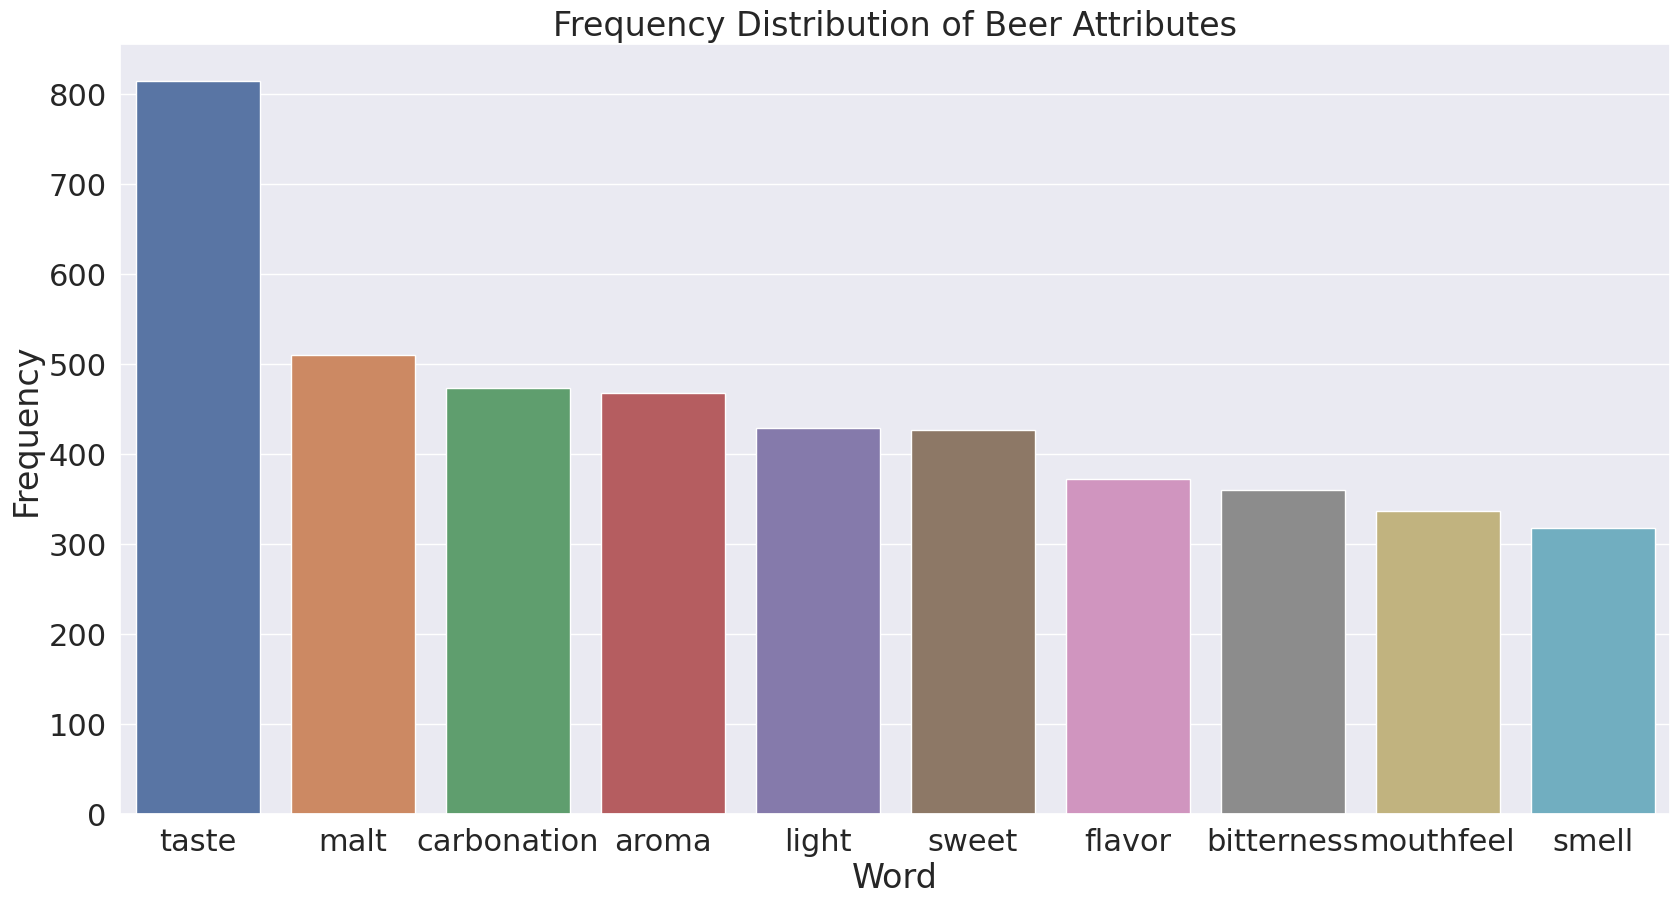

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(font_scale=2)
plt.figure(figsize=(20,10))
sns.barplot(x='Word',y='Frequency',data=top_10Df)
plt.title('Frequency Distribution of Beer Attributes')

**Selected Attributes:**

*   Taste
*   Malt
*   Carbonation

In [ ]:
requested_attributes = top_10Df[:3]

from google.colab import files

requested_attributes.to_csv('Requested_Product_Attributes.csv')
files.download('Requested_Product_Attributes.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### TASK C

We perform a similarity analysis using cosine similarity (without word embeddings) with the 3 attributes specified by the customer and the reviews.


In [ ]:
# Upload the CSV file Requested_Product_Attributes.csv
uploaded_requests = files.upload()

KeyboardInterrupt: ignored

In [ ]:
requested_attributes = pd.read_csv('Requested_Product_Attributes.csv')
three_requested_attributes = requested_attributes['Word'].head(3).tolist()

In [ ]:
!pip install spacy
!python -m spacy download en_core_web_lg
import spacy

nlp = spacy.load("en_core_web_lg")

2023-09-22 02:51:29.506143: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-22 02:51:30.855443: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 2.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [ ]:
def join_words(comment):
    """Joins the tokenized words to a sentence"""
    return " ".join(comment)

data['joined_review'] = data['tokenized_message_unique'].map(join_words)

In [ ]:
#Calculate similarity with pre-processing functions
def calculate_similarity(comment):
    """Compute similarity score"""
    base = nlp(comment)
    compare = nlp(input_attributes)
    return base.similarity(compare)

In [ ]:
input_list = ['taste', 'malt', 'carbonation']
input_attributes =  " ".join(input_list)
data['similarity'] = data['joined_review'].map(calculate_similarity)

In [ ]:
# drop product_review where nan
data.head(10)

,product_name,user_rating,product_review,tokenized_message,tokenized_message_unique,joined_review,similarity
0,Breakfast Stout,4.40,nan,[nan],{nan},nan,-0.013120
1,Breakfast Stout,4.25,nan,[nan],{nan},nan,-0.013120
2,Breakfast Stout,4.94,amazing taste for a dark stout beer!,"[amazing, taste, dark, stout, beer]","{stout, dark, beer, amazing, taste}",stout dark beer amazing taste,0.720091
3,Breakfast Stout,5.00,"well, well, well, well, well. stout lovers of ...","[well, well, well, well, well, stout, lovers, ...","{well, stout, take, unite, world, lovers}",well stout take unite world lovers,0.403161
4,Breakfast Stout,4.20,"had on tap at bulldog saloon lynnwood, wa.","[tap, bulldog, saloon, lynnwood, wa]","{bulldog, lynnwood, wa, tap, saloon}",bulldog lynnwood wa tap saloon,0.126179
5,Breakfast Stout,3.61,i'm rating this based off of the kentucky brea...,"[rating, based, kentucky, breakfast, stout, dr...","{really, objectively, beer, week, breakfast, l...",really objectively beer week breakfast last sp...,0.609459
6,Breakfast Stout,3.84,almost pure black with a small tan head. the b...,"[almost, pure, black, small, tan, head, bubble...","{definitely, black, fast, balance, beer, consi...",definitely black fast balance beer consider ba...,0.663543
7,Breakfast Stout,4.78,nan,[nan],{nan},nan,-0.013120
8,Breakfast Stout,4.37,nan,[nan],{nan},nan,-0.013120
9,Breakfast Stout,5.00,nan,[nan],{nan},nan,-0.013120


In [ ]:
all_reviews = data.sort_values(by='similarity', ascending=False)

In [ ]:
all_reviews

,product_name,user_rating,product_review,tokenized_message,tokenized_message_unique,joined_review,similarity
1044,Bourbon County Brand Coffee Stout,4.24,"aroma is bourbon, coffee, chocolate, dark malt...","[aroma, bourbon, coffee, chocolate, dark, malt...","{flavor, chocolate, slightly, alcohol, mild, a...",flavor chocolate slightly alcohol mild acidic ...,0.853759
3575,Leffe Blonde,4.15,"330ml. bottle in vientiane, laos. pours a clea...","[330ml, bottle, vientiane, laos, pours, clear,...","{aroma, lightly, bitter, malt, medium, acidity...",aroma lightly bitter malt medium acidity sweet...,0.829448
699,Duvel,4.34,"330ml. bottle in mae kasa, thailand. pours a s...","[330ml, bottle, mae, kasa, thailand, pours, sl...","{fairly, slightly, hazy, aroma, overwhelming, ...",fairly slightly hazy aroma overwhelming malt y...,0.827161
3453,Pilsner Urquell,3.84,not as much pilsner malt in the aroma or taste...,"[much, pilsner, malt, aroma, taste, like, pils...","{beer, taste, pilsner, like, aroma, much, good...",beer taste pilsner like aroma much good malt o...,0.818094
737,Bleue (Blue),4.04,"330ml. bottle in vientiane, laos. pours a dark...","[330ml, bottle, vientiane, laos, pours, dark, ...","{floral, caramel, dark, aroma, bitter, malt, y...",floral caramel dark aroma bitter malt yeast me...,0.816180
...,...,...,...,...,...,...,...
4720,Hopsecutioner,3.51,8/2023 sam’s club,"[8, 2023, sam, club]","{2023, 8, sam, club}",2023 8 sam club,-0.016392
4700,Pure Hoppiness,3.93,canned 5/11/21.,"[canned, 5, 11, 21]","{11, 5, 21, canned}",11 5 21 canned,-0.023899
2981,Hop Rod Rye,4.21,packaged 6/7/22.,"[packaged, 6, 7, 22]","{7, packaged, 6, 22}",7 packaged 6 22,-0.025388
2486,Péché Mortel,4.34,bottled on 2016-01-11 12:14lot114,"[bottled, 2016, 01, 11, 12, 14lot114]","{14lot114, 2016, bottled, 11, 01, 12}",14lot114 2016 bottled 11 01 12,-0.031644


In [ ]:
all_reviews_2 = all_reviews

#Dropping the columns:
all_reviews_2.drop(columns=['tokenized_message'], inplace=True)
all_reviews_2.drop(columns=['tokenized_message_unique'], inplace=True)
all_reviews_2.drop(columns=['user_rating'], inplace=True)

In [ ]:
all_reviews_2.drop(columns = ['joined_review'], inplace = True)

In [ ]:
all_reviews_2

,product_name,product_review,similarity
1044,Bourbon County Brand Coffee Stout,"aroma is bourbon, coffee, chocolate, dark malt...",0.853759
3575,Leffe Blonde,"330ml. bottle in vientiane, laos. pours a clea...",0.829448
699,Duvel,"330ml. bottle in mae kasa, thailand. pours a s...",0.827161
3453,Pilsner Urquell,not as much pilsner malt in the aroma or taste...,0.818094
737,Bleue (Blue),"330ml. bottle in vientiane, laos. pours a dark...",0.816180
...,...,...,...
4720,Hopsecutioner,8/2023 sam’s club,-0.016392
4700,Pure Hoppiness,canned 5/11/21.,-0.023899
2981,Hop Rod Rye,packaged 6/7/22.,-0.025388
2486,Péché Mortel,bottled on 2016-01-11 12:14lot114,-0.031644



### TASK D

For every review, we perform a VADER sentiment analysis.


In [ ]:
import csv

reviews = []

#specifies that the file should be interpreted using the UTF-8 character encoding
with open('BeerAdvocateRandR.csv', encoding='utf-8') as csv_file:
    csv_reader = csv.DictReader(csv_file)
    for row in csv_reader:
        # Pulling from review column
        review = row['Review']
        # Removing empty rows
        if review != '':
            reviews.append(review)

In [ ]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [ ]:
# Create a VADER sentiment analyzer object
analyzer = SentimentIntensityAnalyzer()

sentiment_scores = []

for review in reviews:
    sentiments = analyzer.polarity_scores(review)
    sentiment_scores.append(sentiments)

In [ ]:
import numpy as np
import pandas as pd

all_reviews_2['scores'] = all_reviews_2['product_review'].apply(lambda review: analyzer.polarity_scores(review))
all_reviews_2['compound'] = all_reviews_2['scores'].apply(lambda score_dict: score_dict['compound'])
all_reviews_2['comp_score'] = all_reviews_2['compound'].apply(lambda c: 'pos' if c >= 0 else 'neg')

all_reviews_2.rename(columns={'compound': 'sentiment'}, inplace=True)
all_reviews_2.rename(columns={'comp_score': 'sentiment_score'}, inplace=True)

all_reviews_2

,product_name,product_review,similarity,scores,sentiment,sentiment_score,sentiment,sentiment_score
1044,Bourbon County Brand Coffee Stout,"aroma is bourbon, coffee, chocolate, dark malt...",0.853759,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,pos,0.0000,pos
3575,Leffe Blonde,"330ml. bottle in vientiane, laos. pours a clea...",0.829448,"{'neg': 0.065, 'neu': 0.668, 'pos': 0.267, 'co...",0.8316,pos,0.8316,pos
699,Duvel,"330ml. bottle in mae kasa, thailand. pours a s...",0.827161,"{'neg': 0.037, 'neu': 0.924, 'pos': 0.039, 'co...",0.0258,pos,0.0258,pos
3453,Pilsner Urquell,not as much pilsner malt in the aroma or taste...,0.818094,"{'neg': 0.0, 'neu': 0.768, 'pos': 0.232, 'comp...",0.7218,pos,0.7218,pos
737,Bleue (Blue),"330ml. bottle in vientiane, laos. pours a dark...",0.816180,"{'neg': 0.054, 'neu': 0.884, 'pos': 0.061, 'co...",0.0644,pos,0.0644,pos
...,...,...,...,...,...,...,...,...
4720,Hopsecutioner,8/2023 sam’s club,-0.016392,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,pos,0.0000,pos
4700,Pure Hoppiness,canned 5/11/21.,-0.023899,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,pos,0.0000,pos
2981,Hop Rod Rye,packaged 6/7/22.,-0.025388,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,pos,0.0000,pos
2486,Péché Mortel,bottled on 2016-01-11 12:14lot114,-0.031644,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,pos,0.0000,pos


### TASK E

We created an evaluation score for each beer that uses both similarity and sentiment scores

In [ ]:
# Weights for similarity and sentiment
w1, w2 = 0.5, 0.5

top300_reviews_evaluation = top300_reviews_sentiment.copy()

# Compute the evaluation score
top300_reviews_evaluation['evaluation_score'] = (w1 * top300_reviews_sentiment['similarity']) + (w2 * top300_reviews_sentiment['sentiment'])

# Display the updated DataFrame
top300_reviews_evaluation
average_df = top300_reviews_evaluation.groupby(['product_name'])[['evaluation_score']].mean()
average_df.sort_values(by = ['evaluation_score'], ascending=False, inplace=True)
average_df

,evaluation_score
product_name,
Old Chub,0.873822
Abt 12,0.868353
Trois Pistoles,0.864951
Bourbon County Brand Stout,0.862066
Brown Shugga',0.860554
...,...
Alpha King,0.207922
Blackout Stout,0.193264
Daisy Cutter,0.160256


**We recommend:**

Old Chub, Abt 12, Trois Pistoles

### TASK F

Using the top four attributes of beer, we calculated the lifts between these attributes and any 10 beers in our data (choosing one beer and finding the most similar beer among the remaining 9 using the lift values).

In [ ]:
#used the top300_reviews here but will probably need to swap out for the other table. But that may change my commentary
import random
random.seed(10)

top_4_attributes = top_10Df['Word'].head(4).tolist()
beer_names_list = all_reviews_2['product_name'].tolist()
selected_beers = random.sample(beer_names_list, 10)

In [ ]:
import numpy as np

# Create a copy of the data for analysis
scraped = all_reviews_2.copy()
scraped['product_review'] = scraped['product_name'] + ' ' + scraped['product_review']

# Initialize an empty DataFrame to store lift values
lift_table = pd.DataFrame(columns=top_4_attributes, index=selected_beers)

# Loop through beers and attributes to calculate lift values
for i in range(len(selected_beers)):
    for j in range(len(top_4_attributes)):
        beer_count = 0
        attribute_count = 0
        beer_with_attribute_count = 0

        for comment in scraped['product_review']:
            if selected_beers[i] in comment:
                beer_count += 1
                if top_4_attributes[j] in comment:
                    beer_with_attribute_count += 1
            if top_4_attributes[j] in comment:
                attribute_count += 1

        # Calculate lift value based on counts
        lift = ((beer_with_attribute_count * len(scraped)) / (beer_count * attribute_count))

        # Store the lift value in the lift table
        lift_table.loc[selected_beers[i], top_4_attributes[j]] = lift

# Sort the lift table for better readability
lift_table.sort_index(inplace=True)

# Display the lift table
lift_table


,taste,malt,carbonation,aroma
Backwoods Bastard,0.738916,0.993377,0.527426,0.44405
Black Butte Porter,1.231527,1.324503,1.054852,0.44405
Bourbon County Brand Stout,1.231527,0.993377,1.054852,0.888099
Centennial IPA,0.985222,1.324503,0.0,0.888099
Delirium Tremens,0.246305,0.662252,1.582278,0.888099
DirtWolf,1.231527,0.993377,0.527426,1.332149
Festina Pêche,0.738916,0.0,0.527426,0.888099
Julius,1.231527,0.662252,2.109705,0.888099
Punkin Ale,0.985222,0.331126,0.527426,0.44405
Sip Of Sunshine,0.492611,1.324503,0.527426,1.332149


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

#Convert table to array
lift_array = lift_table.values
lift_array

cosine_sim = cosine_similarity(lift_array)

# Print the cosine similarity matrix
print("Cosine Similarity Matrix:")
print(cosine_sim)

Cosine Similarity Matrix:
[[1.         0.98228348 0.95741285 0.91784442 0.7497252  0.91459752
  0.67707464 0.8089612  0.86692951 0.89398928]
 [0.98228348 1.         0.9660396  0.83799585 0.77837093 0.87123792
  0.68454572 0.87330606 0.90107969 0.8146635 ]
 [0.95741285 0.9660396  1.         0.84333106 0.83660509 0.94708852
  0.8460377  0.9216774  0.95234146 0.86699283]
 [0.91784442 0.83799585 0.84333106 1.         0.5228897  0.92776587
  0.63711748 0.5726387  0.77143666 0.90734879]
 [0.7497252  0.77837093 0.83660509 0.5228897  1.         0.71668729
  0.73000492 0.93218061 0.6962055  0.76969965]
 [0.91459752 0.87123792 0.94708852 0.92776587 0.71668729 1.
  0.87472363 0.78077289 0.90596496 0.92542007]
 [0.67707464 0.68454572 0.8460377  0.63711748 0.73000492 0.87472363
  1.         0.82530465 0.88416388 0.71417644]
 [0.8089612  0.87330606 0.9216774  0.5726387  0.93218061 0.78077289
  0.82530465 1.         0.8786862  0.70020013]
 [0.86692951 0.90107969 0.95234146 0.77143666 0.6962055  0.905

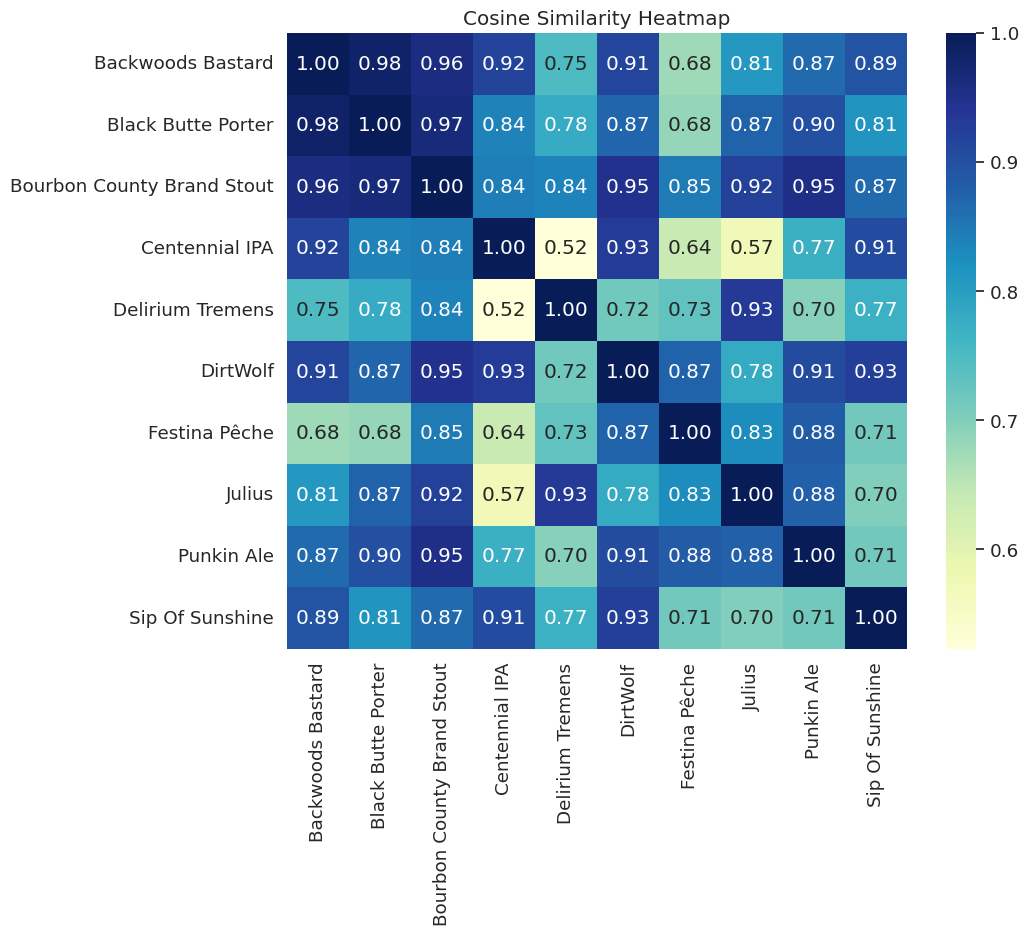

In [ ]:
beer_names = lift_table.index

plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2)  # Adjust the font size
sns.heatmap(cosine_sim, annot=True, cmap="YlGnBu", fmt=".2f", xticklabels=beer_names, yticklabels=beer_names)
plt.title("Cosine Similarity Heatmap")
plt.show()

Each beer brand represents a vector with four distinct directions, one for each attribute. Cosine gives us the angle between each vector. Vectors with the smallest angles between them mean they are the closest in similarity.

We can see that Black Butte Porter and Backwoods Bastard are the most similar.